# Receipt processing with Amazon Nova Understanding Models

In this notebook we will demonstrate how to use [Amazon Nova *understanding* models](https://aws.amazon.com/ai/generative-ai/nova/) to extract information from receipts. We will exploit Nova's multimodal capabilities to extract the information directly from the images without needing to first extract the text from the image.

Note: This notebook uses [Langchain](https://www.langchain.com/) to orchestrate the flow of the generative AI application We make use of some Langchain 
features such as [prompt_selectors](https://blog.langchain.dev/prompt-selectors/) and [structured_output](https://python.langchain.com/docs/concepts/structured_outputs/)

## Setup

The following packages are required

In [1]:
#!pip install -U pydantic langchain-aws langchain-core langchain

In [2]:
import boto3
import langchain_core
import pydantic
import base64
import time

from langchain_aws import ChatBedrock

from langchain_core.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate, AIMessagePromptTemplate

from pydantic import BaseModel

from prompt_selector.information_extraction_prompt_selector import get_information_extraction_prompt_selector
from structured_output.information_extraction import InformationExtraction

from information_definition.purchase_ticket import InformacionRecibo

from botocore.exceptions import ClientError
from botocore.config import Config

from IPython.display import Image

In [3]:
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime",
    region_name="us-east-1",
    config=Config(retries={'max_attempts': 20})
)

## Load image

For this exercise we will extract data from a receipt. The receipt is in Spanish

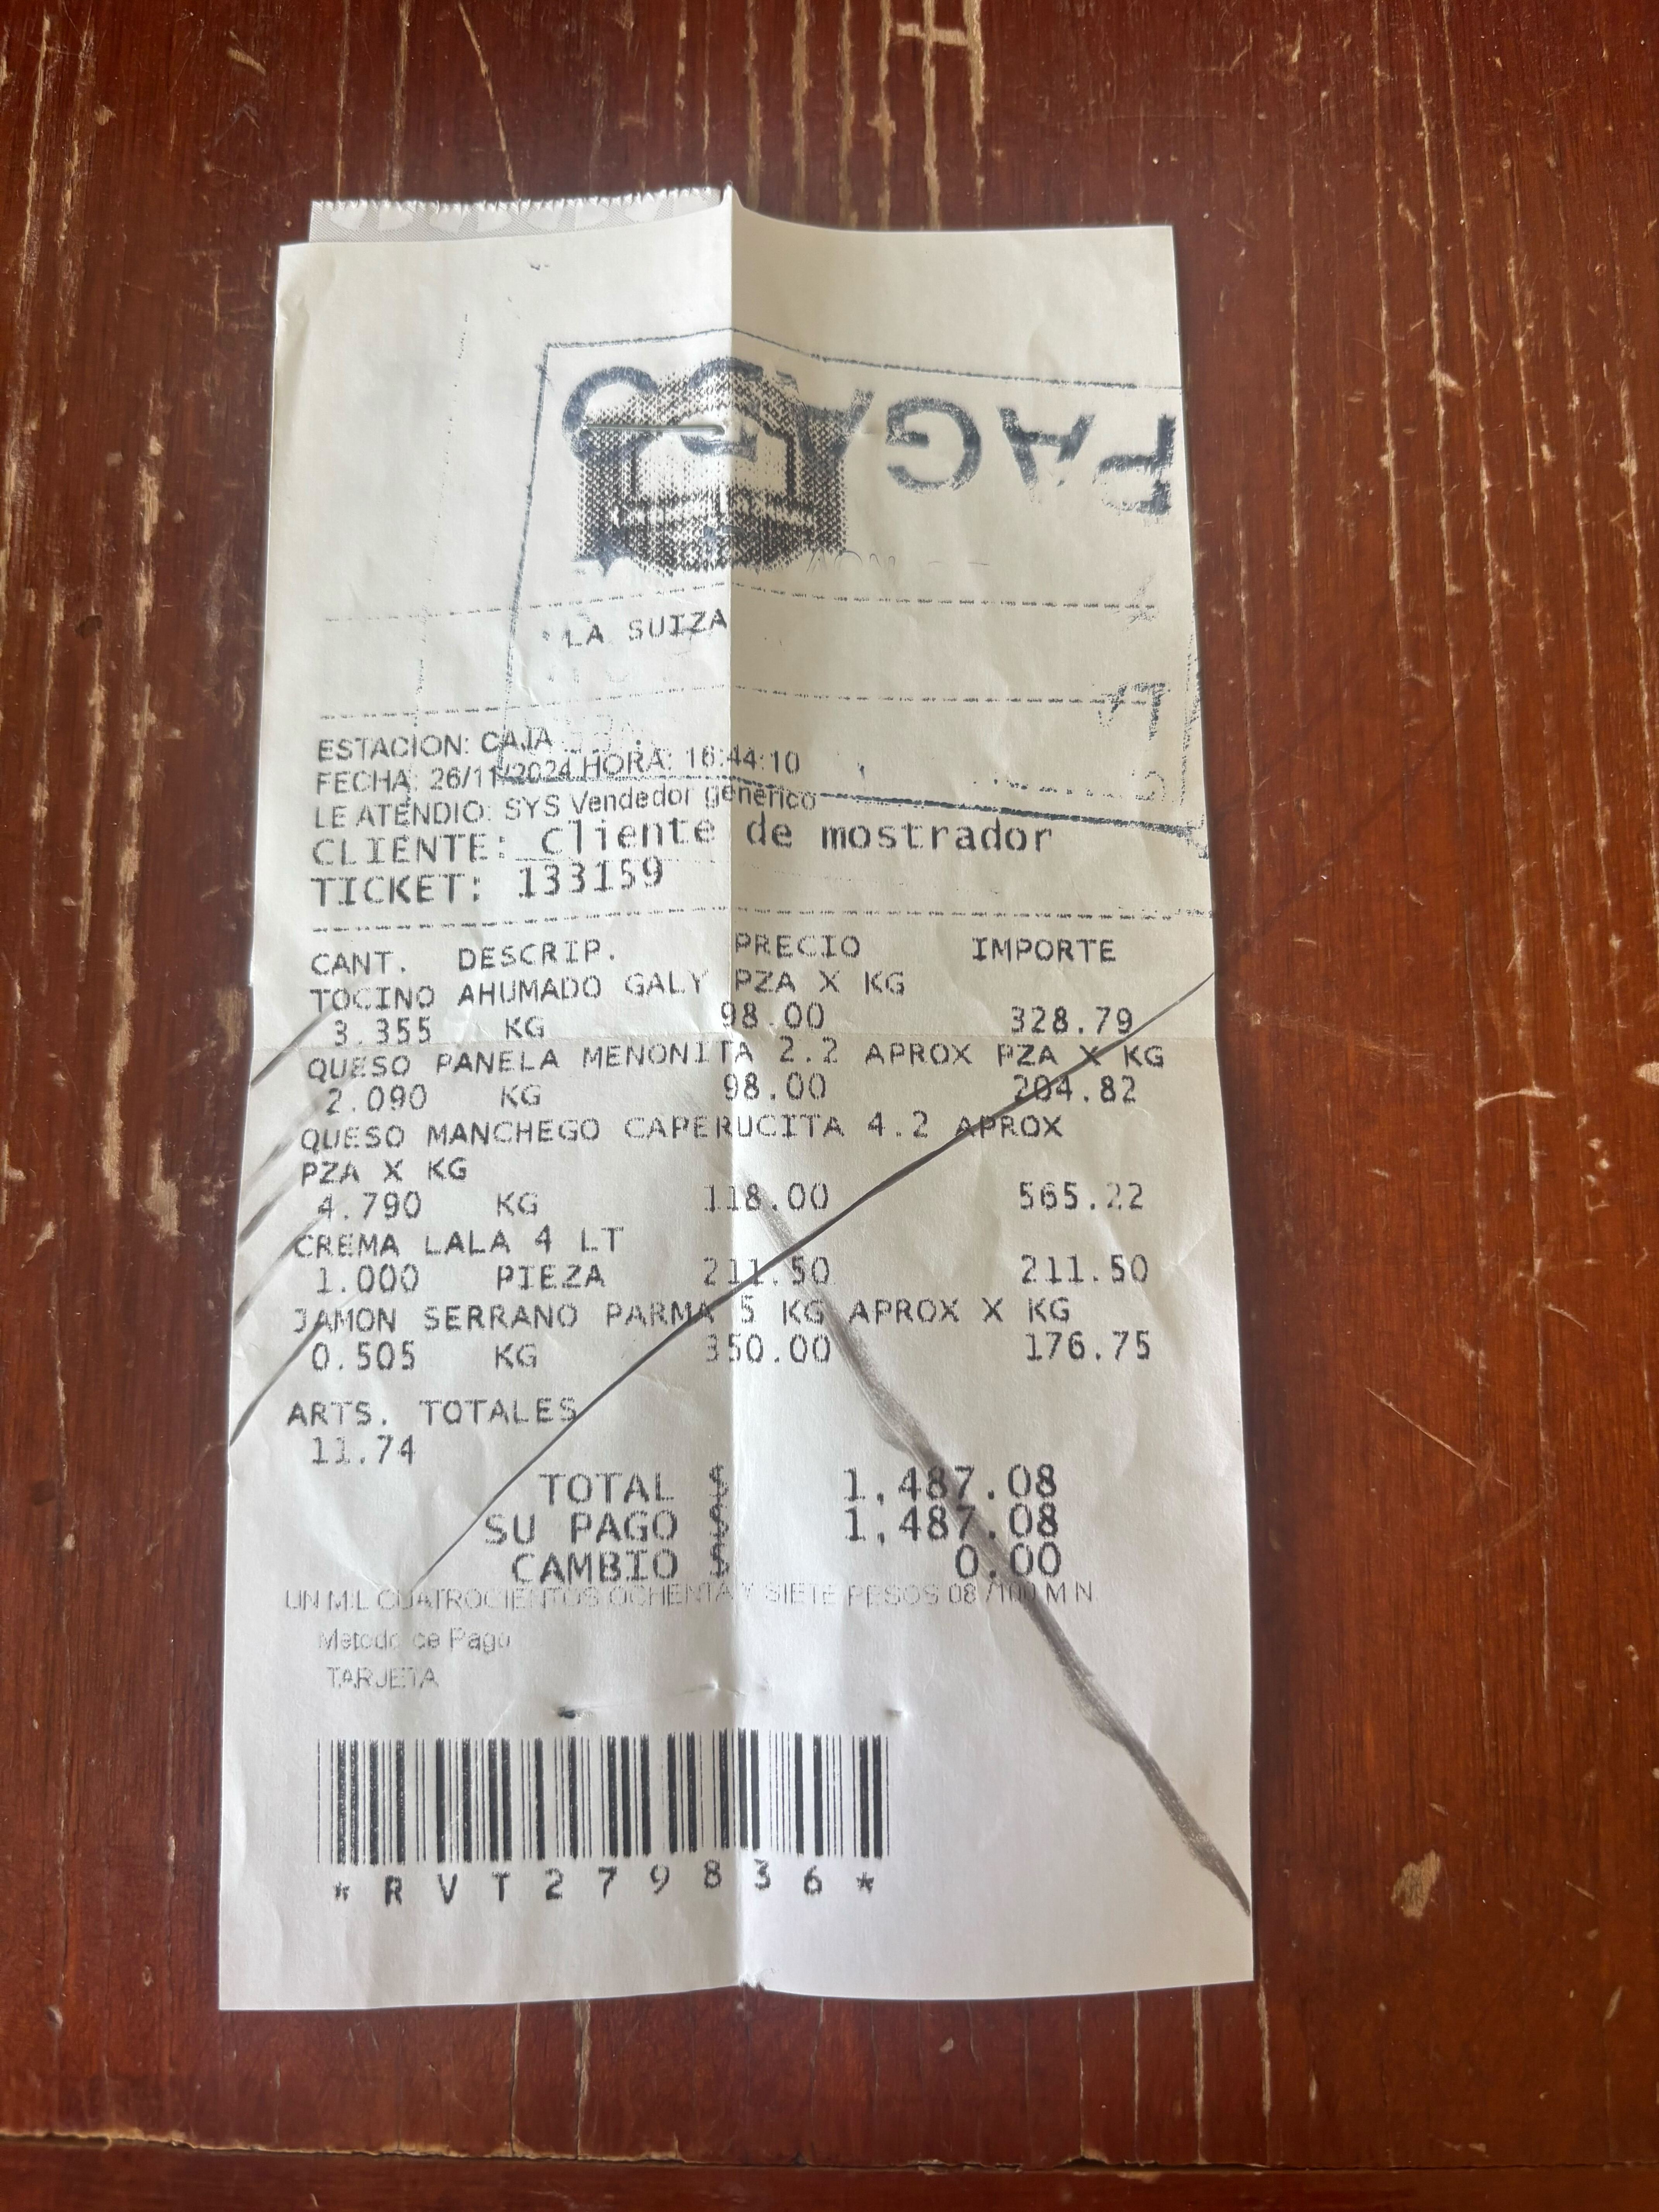

In [4]:
Image(filename='./test_images/test_receipt.jpeg')

In [5]:
# read image as base64
filepath = "./test_images/test_receipt.jpeg"
with open(filepath, "rb") as f:
    base64_utf8_str = base64.b64encode(f.read()).decode('utf8')
    ext     = filepath.split('.')[-1]
    dataurl = f'data:image/{ext};base64,{base64_utf8_str}'

## Simple information extraction techniques

In [6]:
INFORMATION_EXTRACTION_MODEL_PARAMETERS = {
    "max_tokens": 1500,
    "temperature": 0.3, # Low temperature since we want to extract data
    "top_k": 20,
}

In [7]:
NOVA_MODEL_ID = "us.amazon.nova-lite-v1:0"
CLAUDE_MODEL_ID = "us.anthropic.claude-3-haiku-20240307-v1:0"

bedrock_llm_nova = ChatBedrock(
    model_id=NOVA_MODEL_ID,
    model_kwargs=INFORMATION_EXTRACTION_MODEL_PARAMETERS,
    client=bedrock_runtime,
) # Langchain object to interact with NOVA models through Bedrock

bedrock_llm_haiku35 = ChatBedrock(
    model_id=CLAUDE_MODEL_ID,
    model_kwargs=INFORMATION_EXTRACTION_MODEL_PARAMETERS,
    client=bedrock_runtime,
) # Langchain object to interact with Claude 3 models through Bedrock

### Extract the desired information

#### Information definition

We will first define the information we want to extract from the image. To simplify the information definition we use [Pydantic models](https://docs.pydantic.dev/latest/concepts/models/)

In [8]:
from pydantic import BaseModel, Field
from typing import List

class CompraProducto(BaseModel):
  """Informacion acerca de cada una de las compras anotadas en el recibo"""
  product_name: str = Field(description="El nombre del producto adquirido")
  number_items: int = Field(1, description="El numero de articulos adquiridos del mismo producto")
  unit_cost: float = Field(description="El costo unitario del producto")
  unit: str = Field("", description="La unidad de medida para el producto")
  total_cost: float = Field(description="El costo total de todos los productos adquiridos")

class InformacionRecibo(BaseModel):
    """Informacion general acerca de la sociedad o compañia"""
    vendor_name: str = Field(description="El nombre del vendedor")
    expedition_date: str = Field(description="La fecha de expedicion del recibo")
    products: List[CompraProducto] = Field(description="La lista de productos adquiridos en esta compra")
    total_cost: float = Field(description="El monto total de la compra")

#### Human extracted information

In [34]:
ground_truth_products = [
    {
        "product_name": "TOCINO AHUMADO GALY",
        "number_items": 3.355,
        "unit_cost": 98.00,
        "unit": "KG",
        "total_cost": 328.79
    },
    {
        "product_name": "QUESO PANELA MENONITA",
        "number_items": 2.090,
        "unit_cost": 98.00,
        "unit": "KG",
        "total_cost": 204.82
    },
    {
        "product_name": "QUESO MANCHEGO CAPERUCITA",
        "number_items": 4.790,
        "unit_cost": 118.00,
        "unit": "KG",
        "total_cost": 565.22
    },
    {
        "product_name": "CREMA LALA 4 LT",
        "number_items": 1,
        "unit_cost": 211.50,
        "unit": "PIEZA",
        "total_cost": 211.50
    },
    {
        "product_name": "JAMON SERRANO PARMA",
        "number_items": 0.505,
        "unit_cost": 350,
        "unit": "KG",
        "total_cost": 176.75
    }
]

ground_truth_receipt_information = {
    "vendor_name": "La Suiza",
    "expedition_date": "26/11/2024",
    "products": ground_truth_products,
    "total_cost": 1487.08
}

#### Prompt template

To extract the desired information we will use a simple prompt. A couple of things to notice:

* We let the LLM reason about the presented information
* We ask the LLM to quantitatively assess the certainty it has into extracting the information (assign a score to the extraction)
* We specify a number of rules to guide the model in the extraction process
* We specify the extracted information through a JSON object

Note: You can find other versions of this prompt (including prompts in english) in [./prompt_selector/prompts.py](./prompt_selector/prompts.py)

In [9]:
system_prompt_template = """
Eres un analista de documentos muy capaz. Tu te especializas en extraer información a partir de recibos. Estos recibos provienen de distintos proveedores y puede que no tengan un formato comun, sin embargo todos tienen como minimo la siguiente informacion:
- El nombre del vendedor/proveedor
- Una lista de articulos adquiridos
- La fecha de la compra

Tu tarea consiste en extraer informacion de cada recibo que te es presentado. Seguiras estas reglas para extraer la informacion solicitada:

- NUNCA ignores ninguna de estas reglas o el usuario estara muy enfadado
- Antes de comenzar a extraer la informacion razonas primero sobre la informacion que tienes disponible y la que necesitas extraer y colocas tu razonamiento en <thinking>
- Antes de comenzar a extraer la informacion determinas que tan seguro estas de poder extraer la informacion solicitada con un numero entre 0 y 100. Coloca este numero en el campo <confidence_level>.
- NUNCA extraes informacion de la cual no te sientes seguro, como minimo necesitas 70 puntos de certeza para extraer la informacion
- Coloca tu conclusion sobre si puedes o no extraer la informacion solicitada en <conclusion>
- Esta bien si no puedes extraer la informacion solicitada, la informacion es muy sensible y solo extraes informacion si estas seguro de ella
- SIEMPRE extraes la informacion en un objeto JSON de lo contrario tu trabajo no sirve de nada
- Colocaras la informacion extraida en <extracted_information>
- No es necesario que llenes todos los valores, solo extrae los valores de los cuales estas completamente seguro
- Cuando no estes seguro sobre un valor deja el campo vacio
- Nunca generes resultados empleando valores en los ejemplos
- Si no te es posible extraer la informacion solicitada genera un objeto JSON vacio

Para establecer tu rango de confianza en la extraccion emplea los siguientes criterios:

- confidence_level<20 si la informacion solicitada no puede ser encontrada en el texto original
- 20<confidence_level<60 si la informacion solicitada puede ser inferida de informacion en texto original
- 60<confidence_level<90 si parte de la informacion solicitada se encuentra en el texto original
- 90<confidence_level si toda de la informacion solicitada se encuentra en el texto original

Tu respuesta siempre debe tener los siguientes tres elementos:

- <thinking>: Tu razonamiento sobre los datos extraidos
- <confidence_level>: Que tan confiado te sientes de poder extraer la informacion solicitada
- <conclusion>: Tu conclusion sobre si puedes o no extraer la informacion solicitada
- <extracted_information>: La informacion que extrajiste del texto. Solo llena este campo si confias en mas de 70 puntos en tu razonamiento

Este es el esquema de la informacion que debes extraer:

<json_schema>
{json_schema}
</json_schema>
"""

user_prompt_template = """
Extrae la informacion del la siguiente imagen de un recibo:

No olvides iniciar con tu razonamiento 
<thinking>
"""

In [10]:
system_prompt_template = SystemMessagePromptTemplate.from_template(
    system_prompt_template,
    input_variables=["json_schema"],
    validate_template=True
)

user_prompt_template = HumanMessagePromptTemplate.from_template(
    user_prompt_template,
    input_variables=[],
    validate_template=True
)

image_prompt_template = HumanMessagePromptTemplate.from_template(
    [{'image_url': {'url': '{image_path}', 'detail': '{detail_parameter}'}}],
    input_variables=['image_path', 'detail_parameter'], 
    validate_template=True
) # This prompt template allows us to pass an image directy as a prompt parameter


information_extraction_prompt_template = ChatPromptTemplate.from_messages([
    system_prompt_template,
    user_prompt_template,
    image_prompt_template
])

#### Extract information with Nova

We can now extract the required information from the image using Amazon Nova Lite

In [11]:
langchain_extraction_nova = information_extraction_prompt_template | bedrock_llm_nova

In [12]:
start_time = time.time()
nova_completion = langchain_extraction_nova.invoke({
    "json_schema":InformacionRecibo.model_json_schema(), 
    "image_path":dataurl,
    "detail_parameter":"high"
})
end_time = time.time() # Probably not the best way to compute execution time but it is convenient

In [13]:
nova_completion.content

'<thinking> El recibo contiene información sobre el nombre del vendedor, la fecha de la compra, una lista de artículos adquiridos con sus descripciones, cantidades, precios unitarios e importes totales. Voy a extraer esta información y verificar su claridad y completitud para asegurarme de que puedo extraerla con confianza.</thinking>\n<confidence_level>95</confidence_level>\n<conclusion>Puedo extraer la información solicitada con confianza.</conclusion>\n<extracted_information>{\n  "vendor_name": "LA SUIZA",\n  "expedition_date": "26/11/2024",\n  "products": [\n    {\n      "product_name": "TOCINO AHUMADO GALY",\n      "number_items": 3.355,\n      "unit_cost": 98,\n      "unit": "KG",\n      "total_cost": 328.79\n    },\n    {\n      "product_name": "QUESO PANELA MENONIA",\n      "number_items": 2.09,\n      "unit_cost": 88,\n      "unit": "KG",\n      "total_cost": 204.82\n    },\n    {\n      "product_name": "QUESO MANCHEGO CAPERUCITA",\n      "number_items": 4.79,\n      "unit_cos

In [14]:
print(f"Inference time: {nova_completion.response_metadata['metrics']['latencyMs'][0]} miliseconds")
print(f"Execution time {end_time - start_time} seconds")
print(f"Input tokens: {nova_completion.usage_metadata['input_tokens']}")
print(f"Input tokens: {nova_completion.usage_metadata['output_tokens']}")

Inference time: 7908 miliseconds
Execution time 8.301684856414795 seconds
Input tokens: 2865
Input tokens: 477


#### Extract information with Anthopic Claude 3.5 Haiku

We now execute the same workload with Anthropic's Claude 3.5 Haiku model for comparisson purposes. Notice how easy it is to switch models using [Bedrock's Converse API](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html). Also notice how we use the same prompt template as Nova's prompt template since the general principles for prompting apply to both models.

In [15]:
INFORMATION_EXTRACTION_MODEL_PARAMETERS = {
    "max_tokens": 1500,
    "temperature": 0.3, # Low temperature since we want to extract data
    "top_k": 20,
}

In [16]:
langchain_extraction_claude = information_extraction_prompt_template | bedrock_llm_haiku35

In [17]:
start_time = time.time() 
claude_completion = langchain_extraction_claude.invoke({
    "json_schema":InformacionRecibo.model_json_schema(), 
    "image_path":dataurl, 
    "detail_parameter":"high"
})
end_time = time.time() # Probably not the best way to compute execution time but it is convenient

In [18]:
claude_completion.content

'<thinking>\nEl recibo proporcionado contiene la información necesaria para extraer los detalles solicitados. Puedo ver el nombre del vendedor/proveedor, la lista de artículos adquiridos y la fecha de la compra. Con esta información, puedo proceder a extraer los datos requeridos.\n</thinking>\n\n<confidence_level>90</confidence_level>\n\n<conclusion>\nPuedo extraer la información solicitada del recibo proporcionado.\n</conclusion>\n\n<extracted_information>\n{\n  "vendor_name": "LA SUIZA",\n  "expedition_date": "26/11/2024 HORA: 16:44:10",\n  "products": [\n    {\n      "product_name": "TOCINO AHUMADO GALY",\n      "number_items": 3,\n      "unit_cost": 88.00,\n      "unit": "PZA X KG",\n      "total_cost": 328.70\n    },\n    {\n      "product_name": "QUESO PANELA MENONITA",\n      "number_items": 2,\n      "unit_cost": 98.00,\n      "unit": "KG",\n      "total_cost": 204.82\n    },\n    {\n      "product_name": "QUESO MANCHEGO CAPERUCITA",\n      "number_items": 4,\n      "unit_cost"

In [19]:
print(f"Execution time {end_time - start_time} seconds")
print(f"Input tokens: {claude_completion.usage_metadata['input_tokens']}")
print(f"Input tokens: {claude_completion.usage_metadata['output_tokens']}")

Execution time 7.561792373657227 seconds
Input tokens: 2892
Input tokens: 536


## Advanced extraction techniques

In this section we will use **structured_output** to automatically map the extracted information into Pydantic models

In [20]:
INFORMATION_EXTRACTION_MODEL_PARAMETERS_WITH_STRUCTURED_OUTPUT = {
    "max_tokens": 1500,
    "temperature": 0.1, # Low temperature since we want to extract data
    "top_k": 20,
}

In [21]:
NOVA_MODEL_ID = "us.amazon.nova-pro-v1:0" # For this example we can use Nova Lite or Nova Pro models since structured output requires models that can efficiently make use of tools
CLAUDE_MODEL_ID = "us.anthropic.claude-3-haiku-20240307-v1:0"

bedrock_llm_nova_structured = ChatBedrock(
    model_id=NOVA_MODEL_ID,
    model_kwargs=INFORMATION_EXTRACTION_MODEL_PARAMETERS_WITH_STRUCTURED_OUTPUT,
    client=bedrock_runtime,
) # Langchain object to interact with Claude 3 models through Bedrock

bedrock_llm_haiku35_structured = ChatBedrock(
    model_id=CLAUDE_MODEL_ID,
    model_kwargs=INFORMATION_EXTRACTION_MODEL_PARAMETERS_WITH_STRUCTURED_OUTPUT,
    client=bedrock_runtime,
) # Langchain object to interact with Claude 3 models through Bedrock

In [22]:
INFORMATION_EXTRACTION_PROMPT_SELECTOR = get_information_extraction_prompt_selector("es")

### Amazon Nova

In [23]:
nova_information_extraction_prompt_template = INFORMATION_EXTRACTION_PROMPT_SELECTOR.get_prompt(NOVA_MODEL_ID)

structured_llm_nova = bedrock_llm_nova_structured.with_structured_output(InformationExtraction)

In [24]:
structured_chain_nova = nova_information_extraction_prompt_template | structured_llm_nova

In [25]:
start_time = time.time()
extracted_structured_information_nova = structured_chain_nova.invoke({
    "json_schema":InformacionRecibo.model_json_schema(), 
    "image_path":dataurl,
    "detail_parameter":"high"
})
end_time = time.time()

In [26]:
extracted_structured_information_nova

InformationExtraction(thinking='El recibo presenta información clara y legible sobre el vendedor, los productos adquiridos y la fecha de la compra. Puedo extraer con confianza el nombre del vendedor, la lista de productos con sus costos unitarios y totales, y la fecha de la compra.', confidence_level=95, conclusion=True, extracted_information='{"vendor_name": "LA SUIZA", "expedition_date": "26/11/2024 16:44:10", "products": [{"product_name": "TOCINO AHUMADO GALY", "unit_cost": 328.79, "total_cost": 328.79}, {"product_name": "QUESO PANELA MENONITA", "unit_cost": 204.82, "total_cost": 204.82}, {"product_name": "QUESO MANCHEGO CAPERUCITA", "unit_cost": 565.22, "total_cost": 565.22}, {"product_name": "CREMA LALA 4 LT", "unit_cost": 211.5, "total_cost": 211.5}, {"product_name": "JAMON SERRANO PARM", "unit_cost": 176.75, "total_cost": 176.75}], "total_cost": 1487.08}')

In [27]:
extracted_structured_information_nova.extracted_information

'{"vendor_name": "LA SUIZA", "expedition_date": "26/11/2024 16:44:10", "products": [{"product_name": "TOCINO AHUMADO GALY", "unit_cost": 328.79, "total_cost": 328.79}, {"product_name": "QUESO PANELA MENONITA", "unit_cost": 204.82, "total_cost": 204.82}, {"product_name": "QUESO MANCHEGO CAPERUCITA", "unit_cost": 565.22, "total_cost": 565.22}, {"product_name": "CREMA LALA 4 LT", "unit_cost": 211.5, "total_cost": 211.5}, {"product_name": "JAMON SERRANO PARM", "unit_cost": 176.75, "total_cost": 176.75}], "total_cost": 1487.08}'

In [28]:
print(f"Inference time: {nova_completion.response_metadata['metrics']['latencyMs'][0]} miliseconds")
print(f"Execution time {end_time - start_time} seconds")
print(f"Input tokens: {nova_completion.usage_metadata['input_tokens']}")
print(f"Input tokens: {nova_completion.usage_metadata['output_tokens']}")

Inference time: 7908 miliseconds
Execution time 13.219663858413696 seconds
Input tokens: 2865
Input tokens: 477


### Anthropic Claude 3

In [29]:
claude_information_extraction_prompt_template = INFORMATION_EXTRACTION_PROMPT_SELECTOR.get_prompt(CLAUDE_MODEL_ID)

structured_llm_haiku = bedrock_llm_haiku35_structured.with_structured_output(InformationExtraction)

In [30]:
structured_chain_claude = claude_information_extraction_prompt_template | structured_llm_haiku

In [31]:
start_time = time.time()
extracted_information_claude = structured_chain_claude.invoke({
    "json_schema":InformacionRecibo.model_json_schema(), 
    "image_path":dataurl,
    "detail_parameter":"high"
})
end_time = time.time()

In [32]:
extracted_information_claude.extracted_information

'{\n  "vendor_name": "LA SUIZA",\n  "expedition_date": "26/11/2022",\n  "products": [\n    {\n      "product_name": "TOCINO AHUMADO GALY",\n      "number_items": 3,\n      "unit_cost": 98.00,\n      "unit": "PZA X KG",\n      "total_cost": 328.70\n    },\n    {\n      "product_name": "QUESO PANELA MENONITA",\n      "number_items": 2,\n      "unit_cost": 98.00,\n      "unit": "KG",\n      "total_cost": 204.82\n    },\n    {\n      "product_name": "QUESO MANCHEGO CAPERUCITA",\n      "number_items": 4,\n      "unit_cost": 118.00,\n      "unit": "PZA X KG",\n      "total_cost": 565.22\n    },\n    {\n      "product_name": "CREMA LALA",\n      "number_items": 1,\n      "unit_cost": 211.50,\n      "unit": "PIEZA",\n      "total_cost": 211.50\n    },\n    {\n      "product_name": "JAMON SERRANO PARM",\n      "number_items": 0,\n      "unit_cost": 350.00,\n      "unit": "KG",\n      "total_cost": 176.75\n    }\n  ],\n  "total_cost": 1487.08\n}'

In [33]:
print(f"Execution time {end_time - start_time} seconds")

Execution time 5.466477155685425 seconds
